# Explore Data

The first step is exploring data to understand what would be a proper problem setting!

In [1]:
import pandas as pd

dfs = []
for i in range(5):
    df = pd.read_csv(f'outputs/output_res_2019061{i}.csv', index_col='timestamp')
    dfs.append(df)

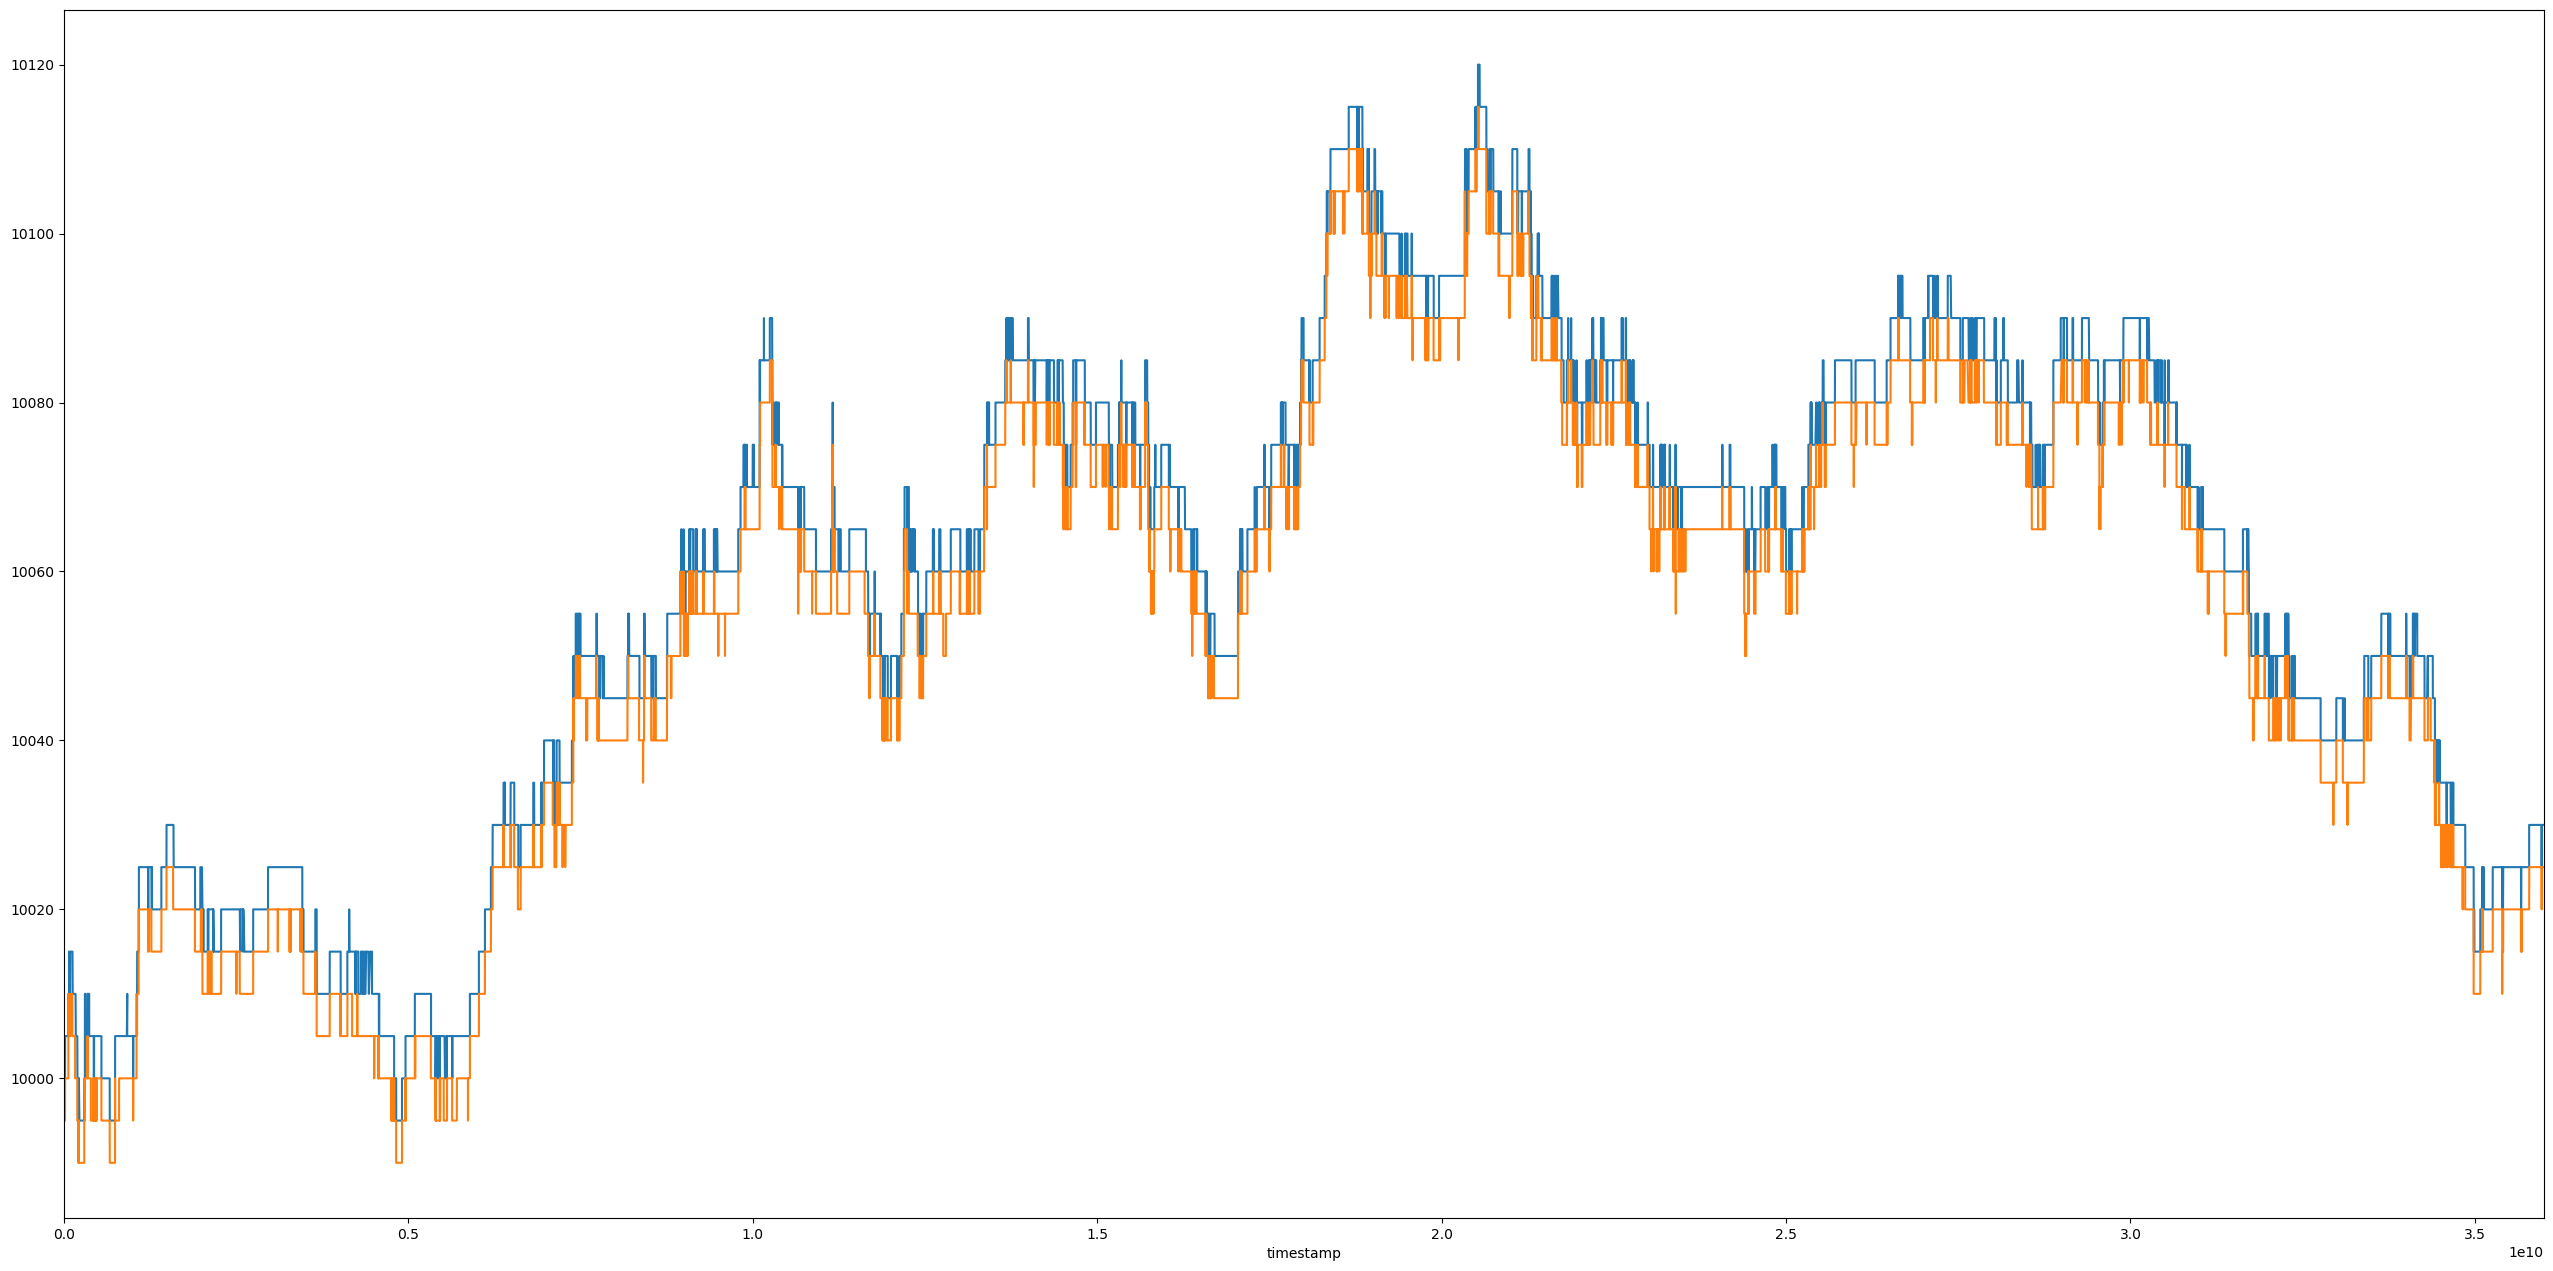

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

dfs[0]['ap0'].plot()
dfs[0]['bp0'].plot()

In [3]:
# Estimate scale of order size for each dataset
quantities = [df['quantity'].sum() for df in dfs]
quantities

[345951, 574523, 730994, 727386, 753507]

In [4]:
# Check how many seconds in each dataset
lengths = [(df.index[-1] - df.index[0]) * 1e-6 for df in dfs]
lengths

[36000.0, 36000.0, 36000.0, 36000.0, 35999.621353999995]

In [5]:
# Check tick size
ask_diffs = [df['ap0'].diff().fillna(0).unique() for df in dfs]
bid_diffs = [df['bp0'].diff().fillna(0).unique() for df in dfs]
print(ask_diffs)
print(bid_diffs)

[array([  0.,   5.,  -5., -10.,  10.]), array([  0.,  -5.,   5., -10.]), array([  0.,  -5.,   5., -10.]), array([  0., -15.,   5.,  -5., -10.,  10.]), array([  0.,   5.,  -5., -15., -10.])]
[array([ 0.,  5., -5., 10.]), array([ 0., -5.,  5.]), array([ 0., -5.,  5., 10.]), array([ 0., -5.,  5.]), array([  0.,   5.,  -5.,  10., -10.])]


In [6]:
# Check the price movement happens with how many seconds on the average
ask_diffs = [df['ap0'].diff().fillna(0) for df in dfs]
ask_diffs = [x[x != 0].shape[0] for x in ask_diffs]
ask_diffs = [lengths[i] / ask_diffs[i] for i in range(len(lengths))]
bid_diffs = [df['bp0'].diff().fillna(0) for df in dfs]
bid_diffs = [x[x != 0].shape[0] for x in bid_diffs]
bid_diffs = [lengths[i] / bid_diffs[i] for i in range(len(lengths))]
print(ask_diffs)
print(bid_diffs)

[27.54399387911247, 13.595166163141993, 11.225444340505145, 11.494252873563218, 11.873226040237466]
[15.901060070671377, 13.688212927756654, 11.331444759206798, 10.650887573964496, 8.65167540350877]


In [7]:
# Check the sacle of bid volume at BBO
[df['aq0'].mean() for df in dfs]

[24.788532609087177,
 48.15029024682058,
 50.452229299363054,
 47.21140255684074,
 40.086708954335805]

In [8]:
# Check the scale of ask volume at BBO
[df['bq0'].mean() for df in dfs]

[43.48558132163414,
 51.89983914351677,
 50.70632233653632,
 48.823602367042895,
 44.94316026339134]

In [9]:
5 / 1e4

0.0005

From the above result, we understand that each data set is 10 hours length and its tick size is 5.
Since the market price is around 1e4 scale, the spread is approximately 5 bips. Even if you do not consider commission, the round trip of execution cost with market order is 10 bips. From my experience, this level execution cost requires you to hold longer periods to overcome the cost if you directly take the statistical edge. In this project, the time period of given datasets is short. Thus, it would be reasonable to trade with two side market making based on fair price estimation. The main logic of two side market making with fair price is attempting to trade products when fair price is favorably deviated from the market price. Here is the simplified steps:

1. Make quoting with short term mean and standard deviation of fair prices.
2. When fair price is getting close to your quoting price within certain level, you shift your quotes away from the fair price.

This logic allows you to trade when fair price deviates from the market price, which helps you to reduce adversally selection cost. To validate the usefulness of fair price estimation, we require synchronized trade and orderbook update dataset. In this project, we are only given orderbook update. So, the target of this project is making fair price with regression.

# Feature Engineering
Although our goal is generating continuous output for fair price, we consider classification to verify and tune the performance.

First, we consider the timeframe for labeling. For fair price prediction, predicting one tick movement would be good enough for labeling positive or negative.

In [10]:
from libs.features import calc_return

def calc_return_ratio(df, period, th):
    returns = calc_return(df, period)
    returns = returns.dropna()
    returns = returns.loc[~returns.index.duplicated(keep='last')]
    ratio = returns.loc[np.abs(returns) >= th].shape[0] / returns.shape[0]
    num_opp = (df.index[-1] - df.index[0]) / period
    return ratio, num_opp, period

In [11]:
import numpy as np
from tqdm import tqdm_notebook

periods = np.logspace(6, 9, 20)
th = 5
ratios = []
num_opportunities = []
for period in tqdm_notebook(periods):
    results = [calc_return_ratio(df, period, th) for df in dfs]
    ratio = np.mean([x[0] for x in results])
    num_opp = np.mean([x[1] for x in results])
    ratios.append(ratio)
    num_opportunities.append(num_opp)

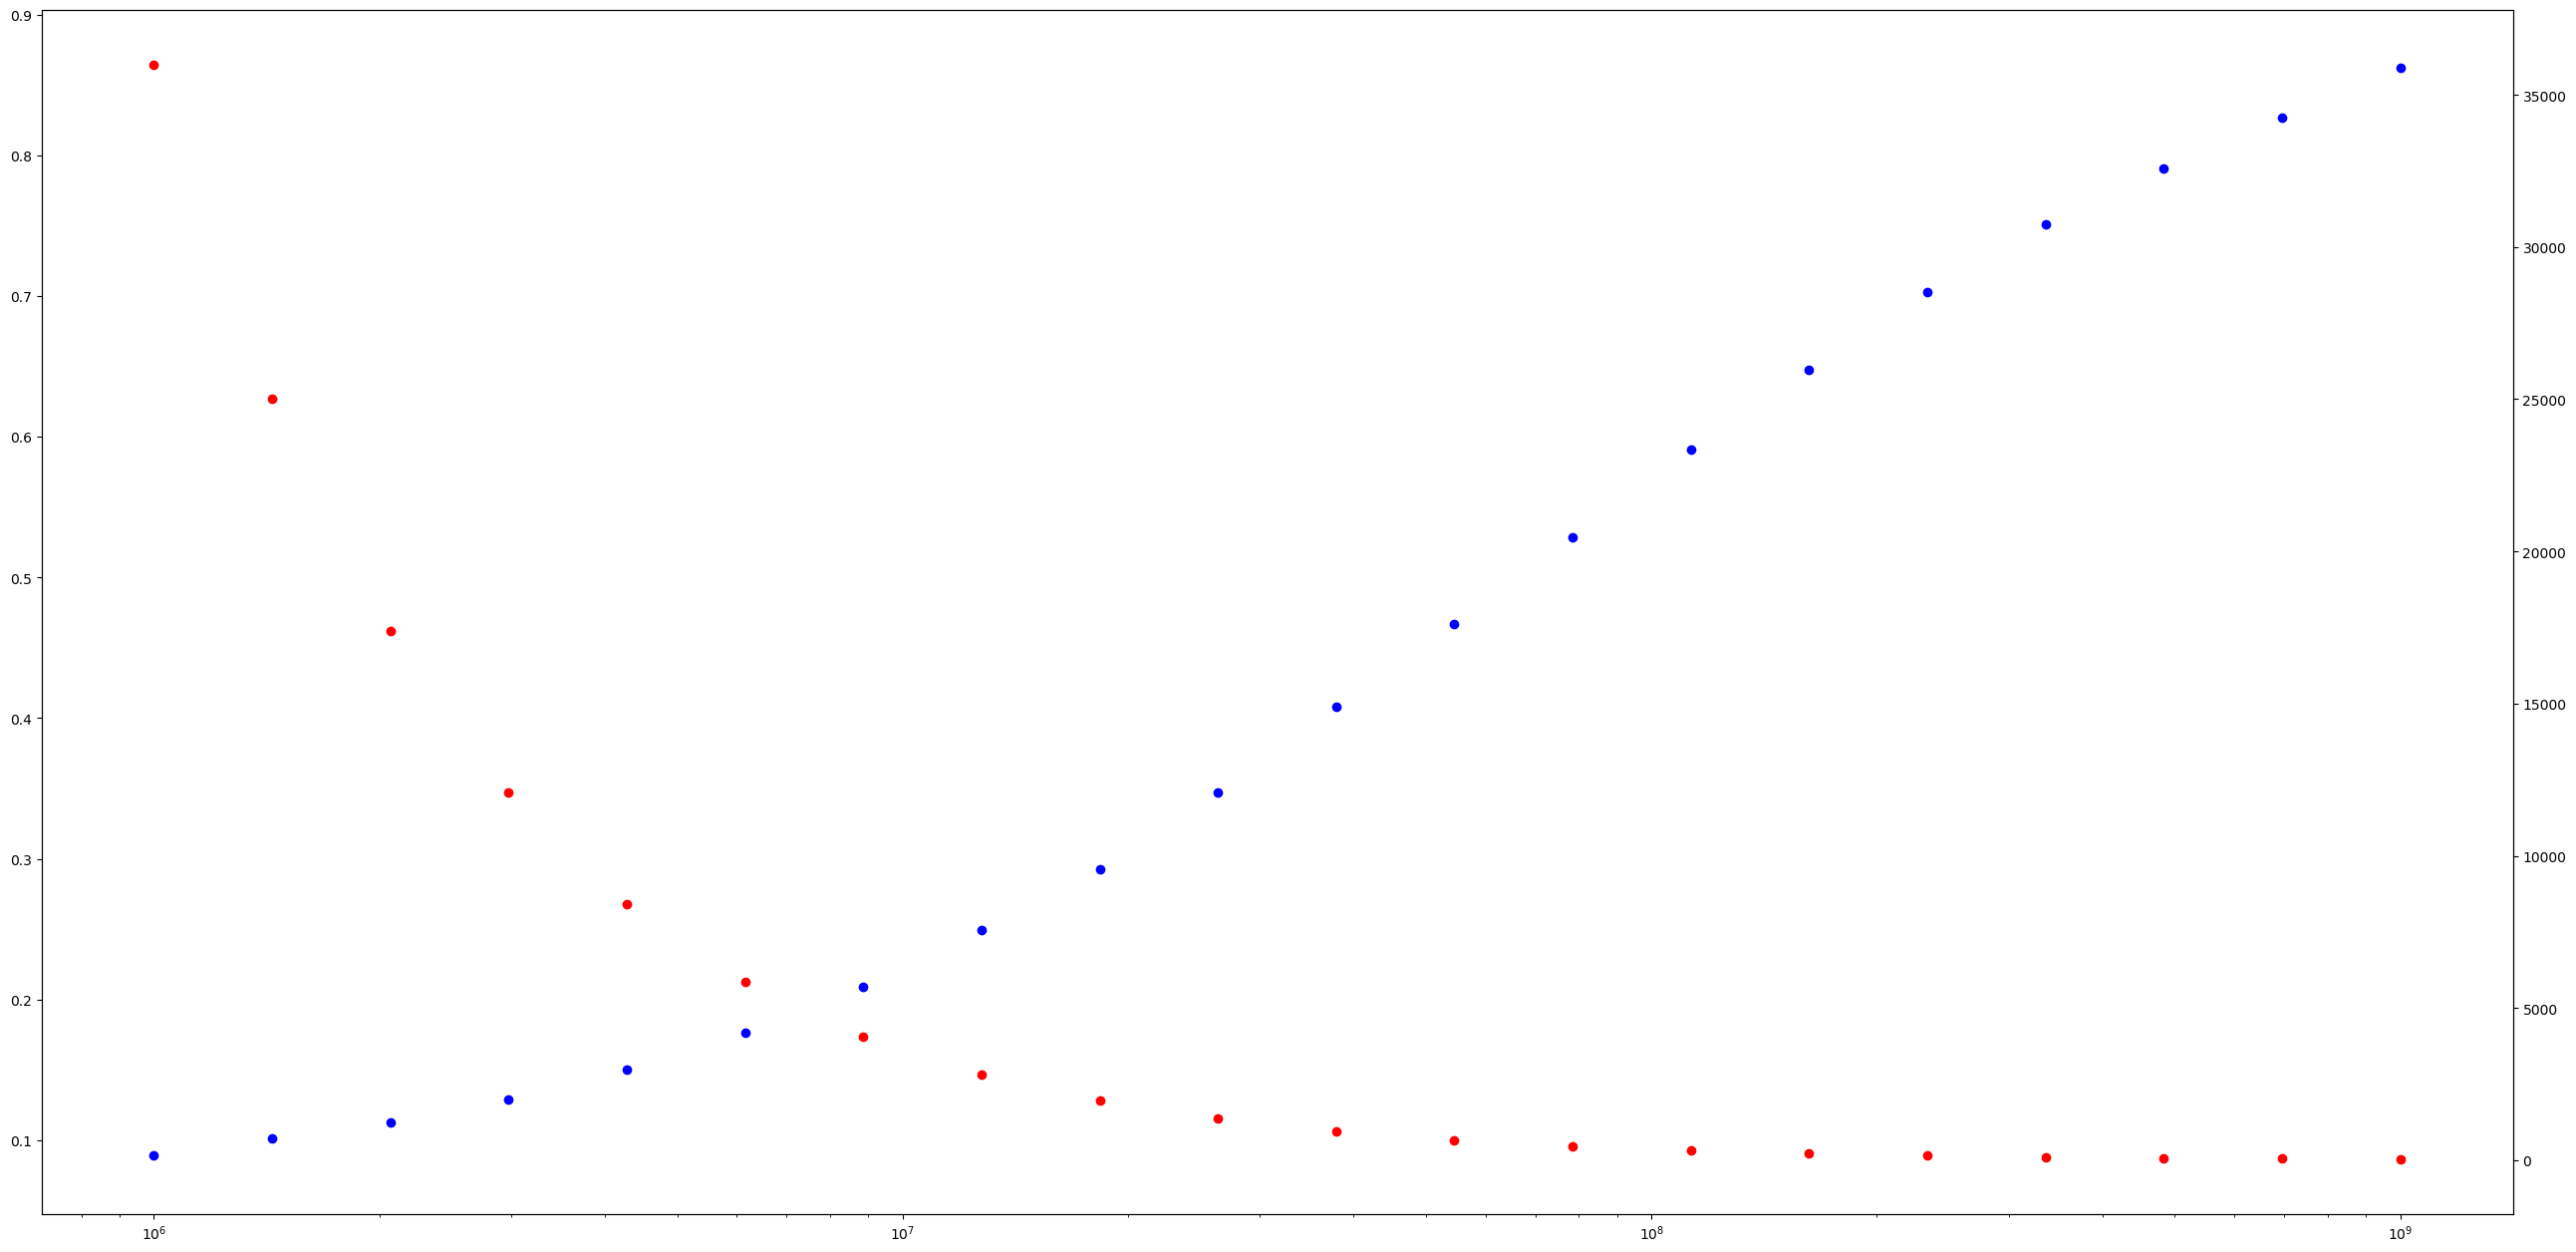

In [12]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(periods, ratios, label='ratio', color='b')
ax2.scatter(periods, num_opportunities, label='num_opp', color='r')
plt.xscale('log')

In [13]:
for i in range(len(periods)):
    print(periods[i], ratios[i])
print('*'*100)
for i in range(len(periods)):
    print(periods[i], num_opportunities[i])

1000000.0 0.08910164167380247
1438449.888287663 0.10134114255876467
2069138.0811147902 0.11236730138559259
2976351.441631319 0.12914329095169746
4281332.3987193955 0.15037671131975286
6158482.110660267 0.1765772922425116
8858667.904100832 0.20886027533002793
12742749.857031321 0.24973364307641913
18329807.108324375 0.2928129233733004
26366508.987303555 0.34715391138206286
37926901.90732254 0.40798065521954785
54555947.811685145 0.46673386747421597
78475997.03514607 0.5286366215495188
112883789.16846883 0.5911813197817841
162377673.91887176 0.6478159380745554
233572146.90901214 0.7029062377117705
335981828.6283788 0.7507706471750232
483293023.85717523 0.790734508367547
695192796.1775591 0.8268933313791764
1000000000.0 0.8620901684878698
****************************************************************************************************
1000000.0 35999.9242708
1438449.888287663 25026.88801599788
2069138.0811147902 17398.512259464245
2976351.441631319 12095.320386986516
4281332.3987193955

From the above results, we consider consider 1e7 scale return.

Next, we consider some basic features: Order Flow Imbalance at BBO, Volume Imbalance at BBO, zscore and volatility from smoothed prices. These features require you to specify period parameter to either of sum up or smooth out. We are going to test predictive power of these features with various periods.

In [14]:
from libs.features import calc_smooth_stats, smooth_signals, calc_order_flow_imbalacne, calc_return
from libs.mp import multi_grid_execution
import multiprocessing as mp
import numpy as np

def generate_features(df, period):
    features = dict()
    mid_prices = 0.5 * (df['ap0'] + df['bp0'])
    spread = df['ap0'] - df['bp0']
    volume_imb = (df['bq0'] - df['aq0']) / (df['bq0'] + df['aq0'])
    mean_prices, vols, zscores = calc_smooth_stats(mid_prices, period)
    features['vol'] = vols
    features['zscore'] = zscores
    ofi = calc_order_flow_imbalacne(df, period)
    features['ofi'] = ofi
    smooth_volume_imb = smooth_signals(volume_imb, period)
    features['volume_imbalance'] = smooth_volume_imb
    return pd.DataFrame(features), period

def generate_features_multi_periods(df, periods):
    features = dict()
    params_conf = [   
        {'name': 'period',  'domain': periods},
    ]

    default_params = {
        'df': df,
    }

    output = multi_grid_execution(params_conf, generate_features, default_params, num_threads=4)
    for x in output:
        features_ = x[0]
        period = x[1]
        for col in features_.columns:
            features[f'{col}_{period}'] = features_[col]
    features = pd.DataFrame(features)
    return features

In [15]:
from tqdm import tqdm_notebook
periods = np.logspace(6, 9, 10)

features = [generate_features_multi_periods(df, periods) for df in tqdm_notebook(dfs)]

2019-12-14 20:34:06.828391 100.0% task done after 1.3 minutes. Remaining 0.0 minutes..
2019-12-14 20:36:14.638874 100.0% task done after 2.13 minutes. Remaining 0.0 minutes.
2019-12-14 20:38:44.005872 100.0% task done after 2.49 minutes. Remaining 0.0 minutes.
2019-12-14 20:41:07.238388 100.0% task done after 2.38 minutes. Remaining 0.0 minutes.


2019-12-14 20:43:39.108154 100.0% task done after 2.53 minutes. Remaining 0.0 minutes.


# Subsampling

Most of machine learning algorithms assume that data is distributed according to I.I.D., which is not the case in finance. Each data point is conditioned on previous data points. To mitigate the redundancy in data samples, we apply subsampling. To subsample, we can consider time, volume, or some other information shift. Our features are based on volume flow and we will consider volume based sampling.

To subsample, we need to check the sacle of order flow at BBO, which is measured through the absolute value of `ofi`.

In [16]:
[np.abs(df['ofi']).cumsum().iloc[-1]/ (10 * 3600) for df in dfs]

[7.367861111111111,
 6.886472222222222,
 12.232083333333334,
 10.073555555555556,
 13.077527777777778]

Each second, around 10 lots flow into BBO.

In [17]:
from libs.features import subsample

help(subsample)

Help on function subsample in module libs.features:

subsample(df, sample_th)
    sample timestamps based on order flow at BBO
    
    Params
    ------
    df: pd.DataFrame
    sample_th: int
        Sampling threashold. For every time cumlative value exceeds
        this value, we sample timestamp
    
    Returns
    -------
    list(int), sampled timestamp



In [18]:
timestamps = [subsample(df, 10) for df in dfs]
print([len(timestamps[i]) / len(dfs[i]) for i in range(len(dfs))])

[0.0828092469725458, 0.0607302698630744, 0.06314643838017882, 0.06448441582503678, 0.07347813073597133]


We have reduced sampling points around 10 - 20 times.

# Feature Selection

While Lasso is able to reduce the dimension of active features due to the nature of exponential prior in the Bayesian view, these selection depends on choosing proper regularization parameter. Financial data is low signal-to-noise ratio and easily leads to overfitting. Thus, it would be good idea to nail down informative features in advance. To estimate feature importance, we consier a classification problem.

In this classification, we label points as 1 or -1 if the mid price goes up or down 1 tick. Otherwise, they are labeled as 0.

In [19]:
from libs.features import calc_return

def generate_labels(df, period, th):
    returns = calc_return(df, period)
    labels = pd.Series(0, index=returns.index)
    labels[np.abs(returns) >= th] = 1
    labels[returns <= -th] = -1
    return labels

Subsampling!

In [20]:
period = 1e7
th = 5
labels = [generate_labels(df, period, th) for df in dfs]
returns = [calc_return(df, period) for df in dfs]
returns = [x.loc[~x.index.duplicated()] for x in returns]
labels = [label.loc[~label.index.duplicated()] for label in labels]
features = [feature.loc[~feature.index.duplicated()] for feature in features]
sub_labels = [labels[i].loc[timestamps[i]] for i in range(len(timestamps))]
sub_features = [features[i].loc[timestamps[i]] for i in range(len(timestamps))]
sub_returns = [returns[i].loc[timestamps[i]] for i in range(len(timestamps))]

Let's look at feature importance. The original feature importance implmeneted inside RandomForest of scikit learn tends to inflate importance score beacause financial data are not I.I.D. and contains a lot of noises. Subsampling of RandomForest does not eliminate information of not sampled data points. I have implemented function `feat_imp_MDA`. This feature importance estimation based on cross validation. In the test samples, it randomizes a feature and see if the accuracy decreases. If the accuracy decreases, it implies that the feature has predictive power. Since we want to see if certain features contributes to the price movement. Inside the function, we check only the points of either of 1 or -1 label.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from libs.features import feat_imp_MDA

print(help(feat_imp_MDA))

clf = RandomForestClassifier(n_jobs=4, n_estimators=100)
results = feat_imp_MDA(clf, sub_features, sub_labels)

Help on function feat_imp_MDA in module libs.features:

feat_imp_MDA(clf, features, labels)
    Calculate Mean Decrease Accuracy
    
    Params
    ------
    clf: Classifier instance
    features: list(pd.DataFrae)
    labels:  list(pd.Series) 
    
    Returns
    -------
    imp: pd.DataFrame, feature importance of means and standard deviations
    scores: float, scores of cross validation

None


/Users/tomfujii/work/Development/project/libs/features.py:229: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  X_train = pd.concat(X_train)
/Users/tomfujii/work/Development/project/libs/features.py:229: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  X_train = pd.concat(X_train)
/Users/tomfujii/work/Development/project/libs/features.py:229: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence t

In [22]:
scores = results[0]['mean']
scores.sort_values(ascending=False)

ofi_464158883.3612773                  0.003120
zscore_1000000000.0                    0.002698
zscore_4641588.833612782               0.001691
vol_21544346.900318824                 0.000966
ofi_4641588.833612782                  0.000661
ofi_100000000.0                        0.000387
volume_imbalance_4641588.833612782     0.000380
ofi_1000000.0                          0.000336
ofi_2154434.6900318824                 0.000221
vol_464158883.3612773                  0.000220
vol_1000000.0                          0.000218
volume_imbalance_100000000.0           0.000203
vol_46415888.33612773                  0.000175
ofi_215443469.00318778                 0.000032
vol_2154434.6900318824                 0.000031
vol_10000000.0                         0.000024
vol_1000000000.0                       0.000006
volume_imbalance_21544346.900318824    0.000000
volume_imbalance_10000000.0           -0.000077
vol_100000000.0                       -0.000086
volume_imbalance_1000000000.0         -0

In [23]:
import json

# Save positive importance feature names
feature_filename = "feature_names.txt"
file = open(feature_filename, 'w')
select_names = scores[scores > 0].index
select_names = list(select_names)
print(select_names)
json.dump(select_names, file)
file.close()
select_features = [feature[select_names] for feature in sub_features]

['vol_1000000.0', 'ofi_1000000.0', 'vol_2154434.6900318824', 'ofi_2154434.6900318824', 'vol_10000000.0', 'zscore_4641588.833612782', 'ofi_4641588.833612782', 'volume_imbalance_4641588.833612782', 'vol_21544346.900318824', 'vol_46415888.33612773', 'ofi_100000000.0', 'volume_imbalance_100000000.0', 'ofi_215443469.00318778', 'vol_464158883.3612773', 'ofi_464158883.3612773', 'vol_1000000000.0', 'zscore_1000000000.0']


# Generate Models

The next step is tuning models. Since we use Lasso, the possible hyper parameter is intercept and regularization 
parameter. Since we predict future returns and want to neutrize output for both direction, we set intercept into 0.
So, hyper parameter we consider here is only alpha, regularization parameter. For validation score, we use the proxy of pnl without the cost by translating output into classification output, -1, 0, or 1.

In [24]:
from libs.model import Model
from libs.pandas_utils import get_non_duplicated, subsample_returns

def evaluate(model, features, returns, th=5):
    pred = model.predict_clf(features, th)
    # Proxy of PnL
    score = returns.values * pred
    score = np.mean(score)
    return score

def validation(model, features, returns, period, th=5, **kwargs):
    scores = []
    for i in range(len(features)):
        test_features = features[i]
        test_returns = returns[i]
        X_test = get_non_duplicated(test_features)
        y_test = get_non_duplicated(test_returns)
        cond = (~y_test.isnull()) & (X_test.isnull().sum(axis=1) == 0)
        X_test = X_test.loc[cond]
        y_test = y_test.loc[cond]
        X_train = []
        y_train = []
        for j in range(len(features)):
            if i == j:
                continue
            train_features = features[j]
            train_returns = returns[j]
            train_features = get_non_duplicated(train_features)
            train_returns = get_non_duplicated(train_returns)
            cond = (~train_returns.isnull()) & (train_features.isnull().sum(axis=1) == 0)
            train_features = train_features.loc[cond]
            train_returns = train_returns.loc[cond]
            X_train.append(train_features)
            y_train.append(train_returns)
        X_train = pd.concat(X_train)
        y_train = pd.concat(y_train)
        # Add hoc down sampling
        X_train, y_train = subsample_returns(X_train, y_train, th)
        model.fit(X_train.values, y_train.values)
        score = evaluate(model, X_test, y_test, th=th)
        scores.append(score)
    return np.mean(scores)

def model_selection(select_features, dfs, period, th, **kwargs):
    model = Model(**kwargs)
    score = validation(model, select_features, dfs, period, th)
    params = {
        'period': period,
        'th': th,
    }
    params.update(kwargs)
    return score, params

def multi_model_selection(select_features, dfs, params_conf):
    default_params = {
        'dfs': dfs,
        'select_features': select_features,
    }

    output = multi_grid_execution(params_conf, model_selection, default_params)
    return output

In [25]:
alphas = np.logspace(-3, 1, 20)
params_conf = [
    {'name':'alpha', 'domain': alphas},
    {'name': 'period', 'type': 'fixed', 'domain': 1e7},
    {'name': 'th', 'type': 'fixed', 'domain': 5},
]

output = multi_model_selection(select_features, sub_returns, params_conf)

2019-12-14 20:44:15.333014 100.0% task done after 0.07 minutes. Remaining 0.0 minutes.


In [26]:
output.sort(key=lambda x: x[0], reverse=True)

In [27]:
output[0]

(0.0023087264013092524,
 {'period': 10000000.0, 'th': 5, 'alpha': 0.07847599703514611})

In [28]:
import json

# Save best parameters
best_params = {'alpha': output[0][1]['alpha']}
filename = "model_params.txt"
file = open(filename, 'w')
print(best_params)
json.dump(best_params, file)
file.close()

{'alpha': 0.07847599703514611}


# Generate Fair Prices

The final step is generating fair prices. Since our model predicts future returns, we add the outputs of the model to mid prices to generate fair prices. In the model fitting phase, we apply downsampling. In the high frequency data, the most of returns would be zero. Then, your model tends to fit 0 returns and generate outputs close to 0. To mitigate this effect, I downsamples small return points for fitting phase. One of the typical methods to do that is allocating weights according to absolute return size. In this project, for the sake of simplicity, I simply balance the number of returns lower than 1 tick and that of ones more that 1 tick.

In [29]:
import json

from libs.model import Model
from libs.features import load_feature_config, subsample, calc_return, generate_features
from libs.pandas_utils import get_non_duplicated, subsample_returns
        

def generate_signals(dfs, feature_names_filename, model_params_filename, period=1e7, sample_th=10,
                     returns_th=5):
    file = open(model_params_filename, 'r')
    model_params = json.load(file)
    file.close()
    features_config = load_feature_config(feature_names_filename)
    timestamps = [subsample(df, sample_th) for df in dfs]
    model = Model(**model_params)
    returns = [calc_return(df, period) for df in dfs]
    features = [generate_features(df, features_config) for df in dfs]
    returns = [calc_return(df, period) for df in dfs]
    returns = [get_non_duplicated(x) for x in returns]
    features = [get_non_duplicated(feature) for feature in features]
    sub_features = [features[i].loc[timestamps[i]] for i in range(len(timestamps))]
    sub_returns = [returns[i].loc[timestamps[i]] for i in range(len(timestamps))]
    signal_prices_list = []
    for i in range(len(features)):
        test_features = features[i]
        X_test = get_non_duplicated(test_features)
        cond = (X_test.isnull().sum(axis=1) == 0)
        X_test = X_test.loc[cond]
        df = get_non_duplicated(dfs[i])
        df = df.loc[cond]
        mid_prices = 0.5 * (df['ap0'] + df['bp0'])
        X_train = []
        y_train = []
        for j in range(len(features)):
            if i == j:
                continue
            train_features = sub_features[j]
            train_returns = sub_returns[j]
            cond = (~train_returns.isnull()) & (train_features.isnull().sum(axis=1) == 0)
            train_features = train_features.loc[cond]
            train_returns = train_returns.loc[cond]
            X_train.append(train_features)
            y_train.append(train_returns)
        X_train = pd.concat(X_train)
        y_train = pd.concat(y_train)
        X_train, y_train = subsample_returns(X_train, y_train, returns_th)
        model.fit(X_train.values, y_train.values)
        pred = model.predict(X_test)
        pred = pd.Series(pred, index=X_test.index)
        signal_prices = mid_prices + pred
        signal_prices_list.append(signal_prices)
    return signal_prices_list

In [30]:
period = 1e7
sample_th = 10
feature_names_filename = "feature_names.txt"
model_params_filename = "model_params.txt"
signal_prices_list = generate_signals(dfs, feature_names_filename,
                                      model_params_filename, period, sample_th)

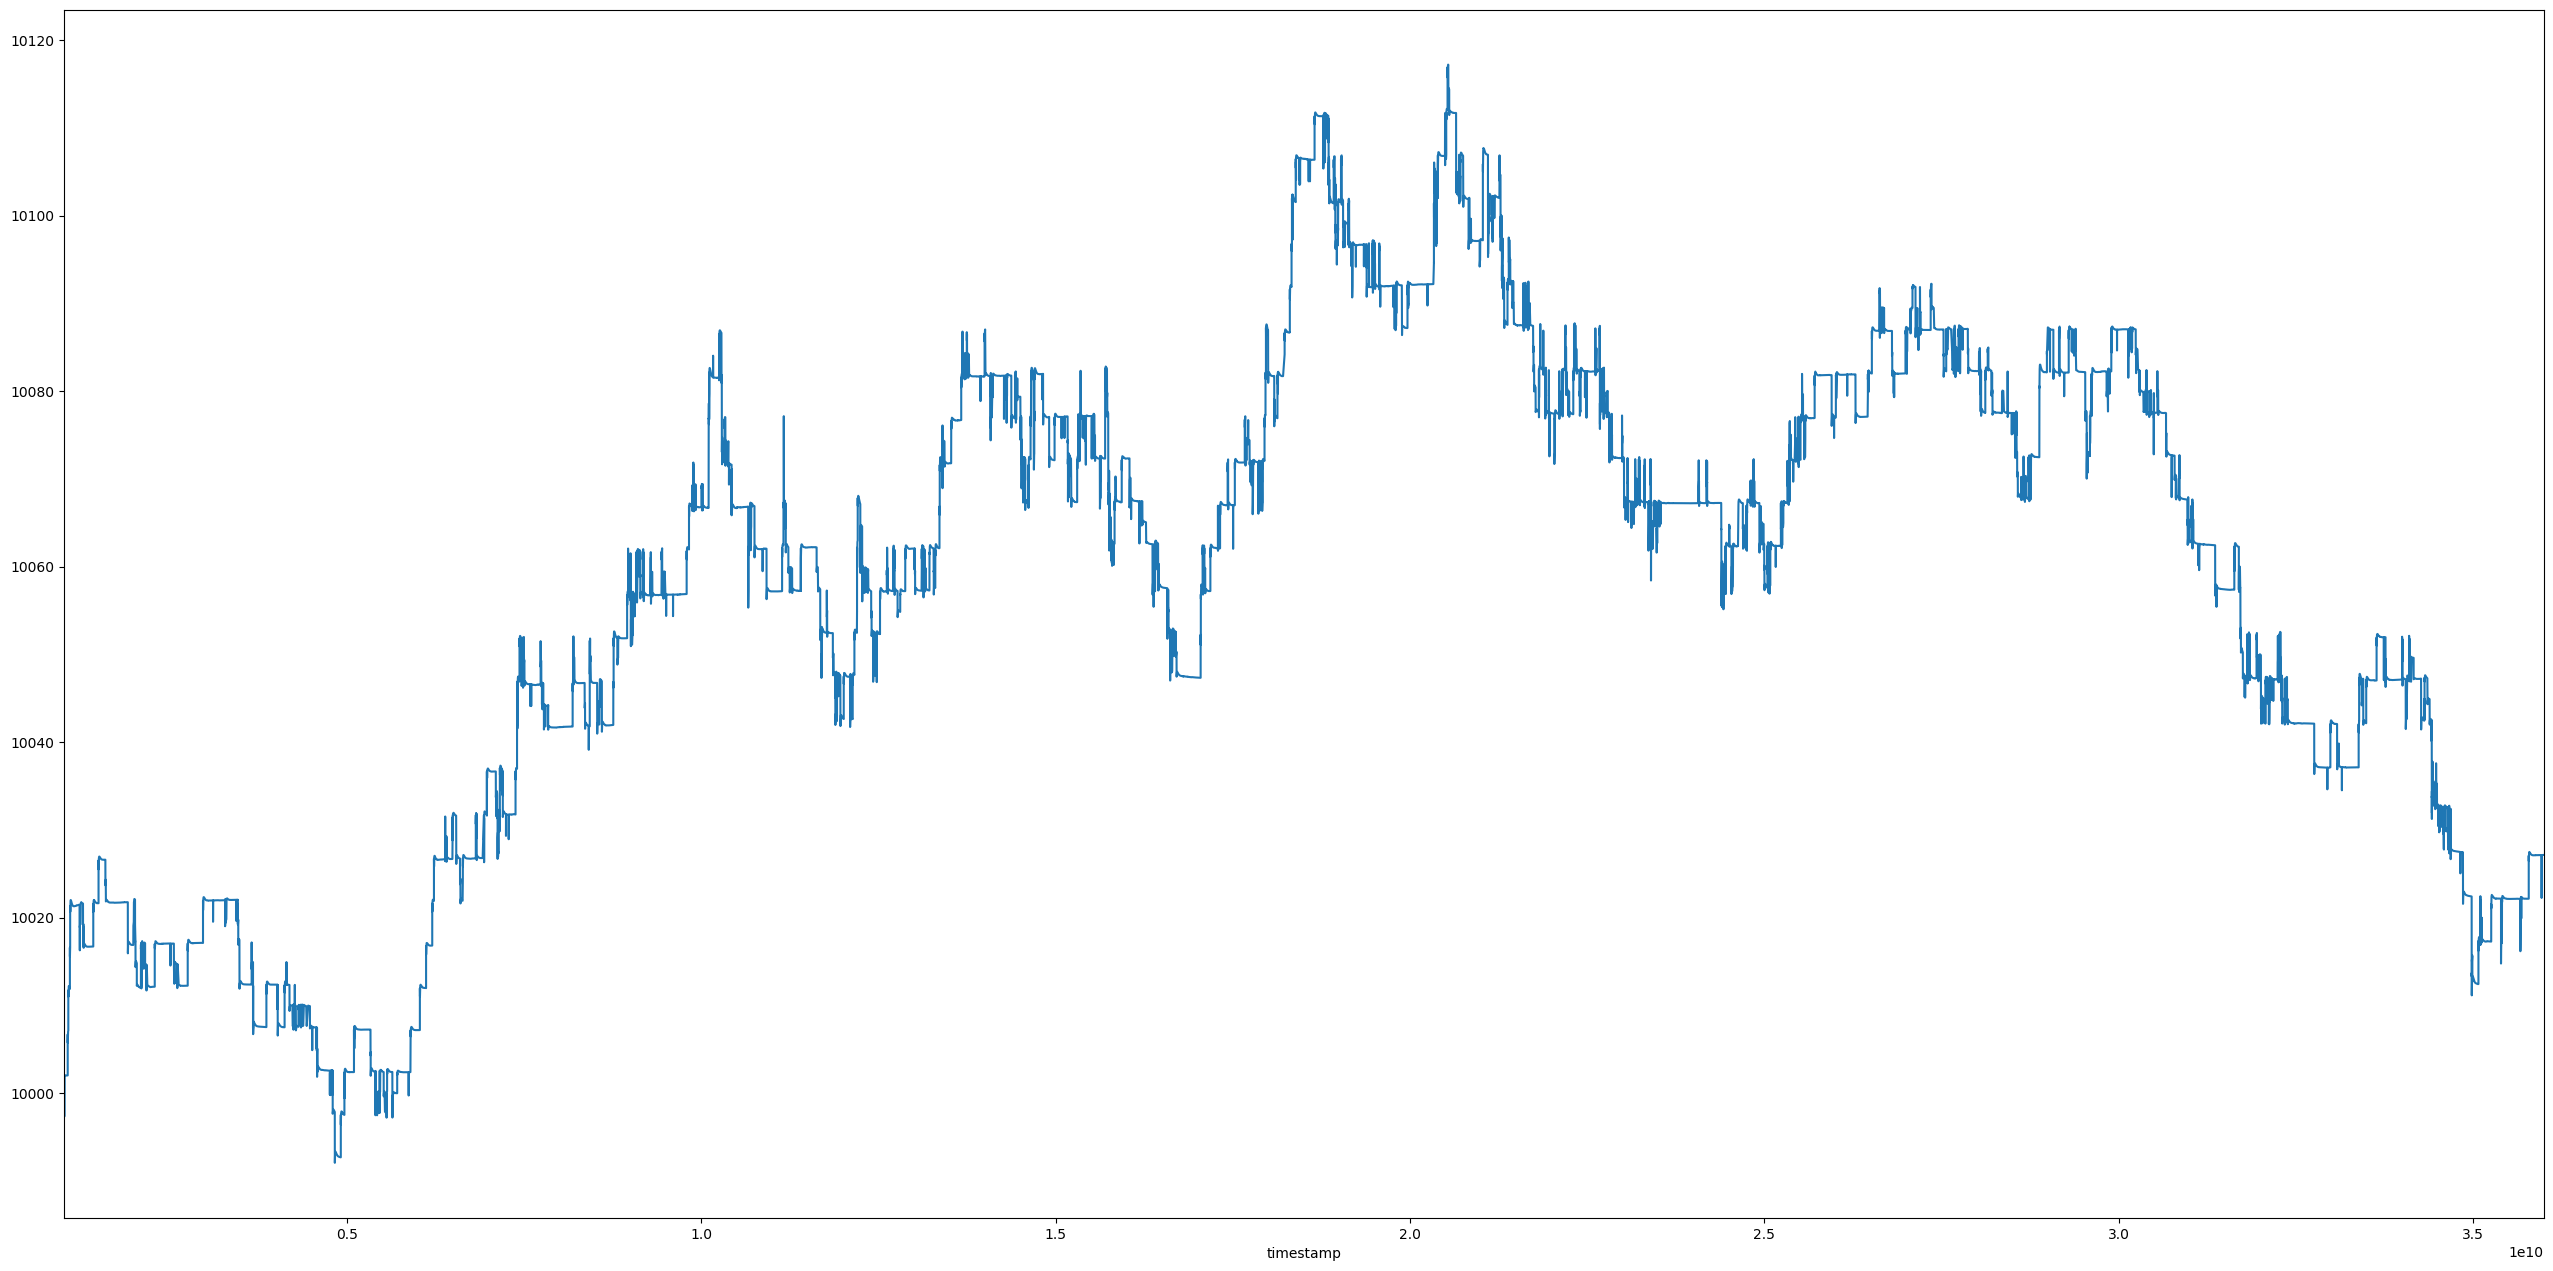

In [31]:
signal_prices_list[0].plot()

In [32]:

for i in range(len(signal_prices_list)):
    filename = f'fair_prices/fair_prices{i}.csv'
    fair_prices = signal_prices_list[i]
    fair_prices.to_csv(filename, index=True, header=True)

In [33]:
x = pd.read_csv('fair_prices/fair_prices0.csv', index_col='timestamp')

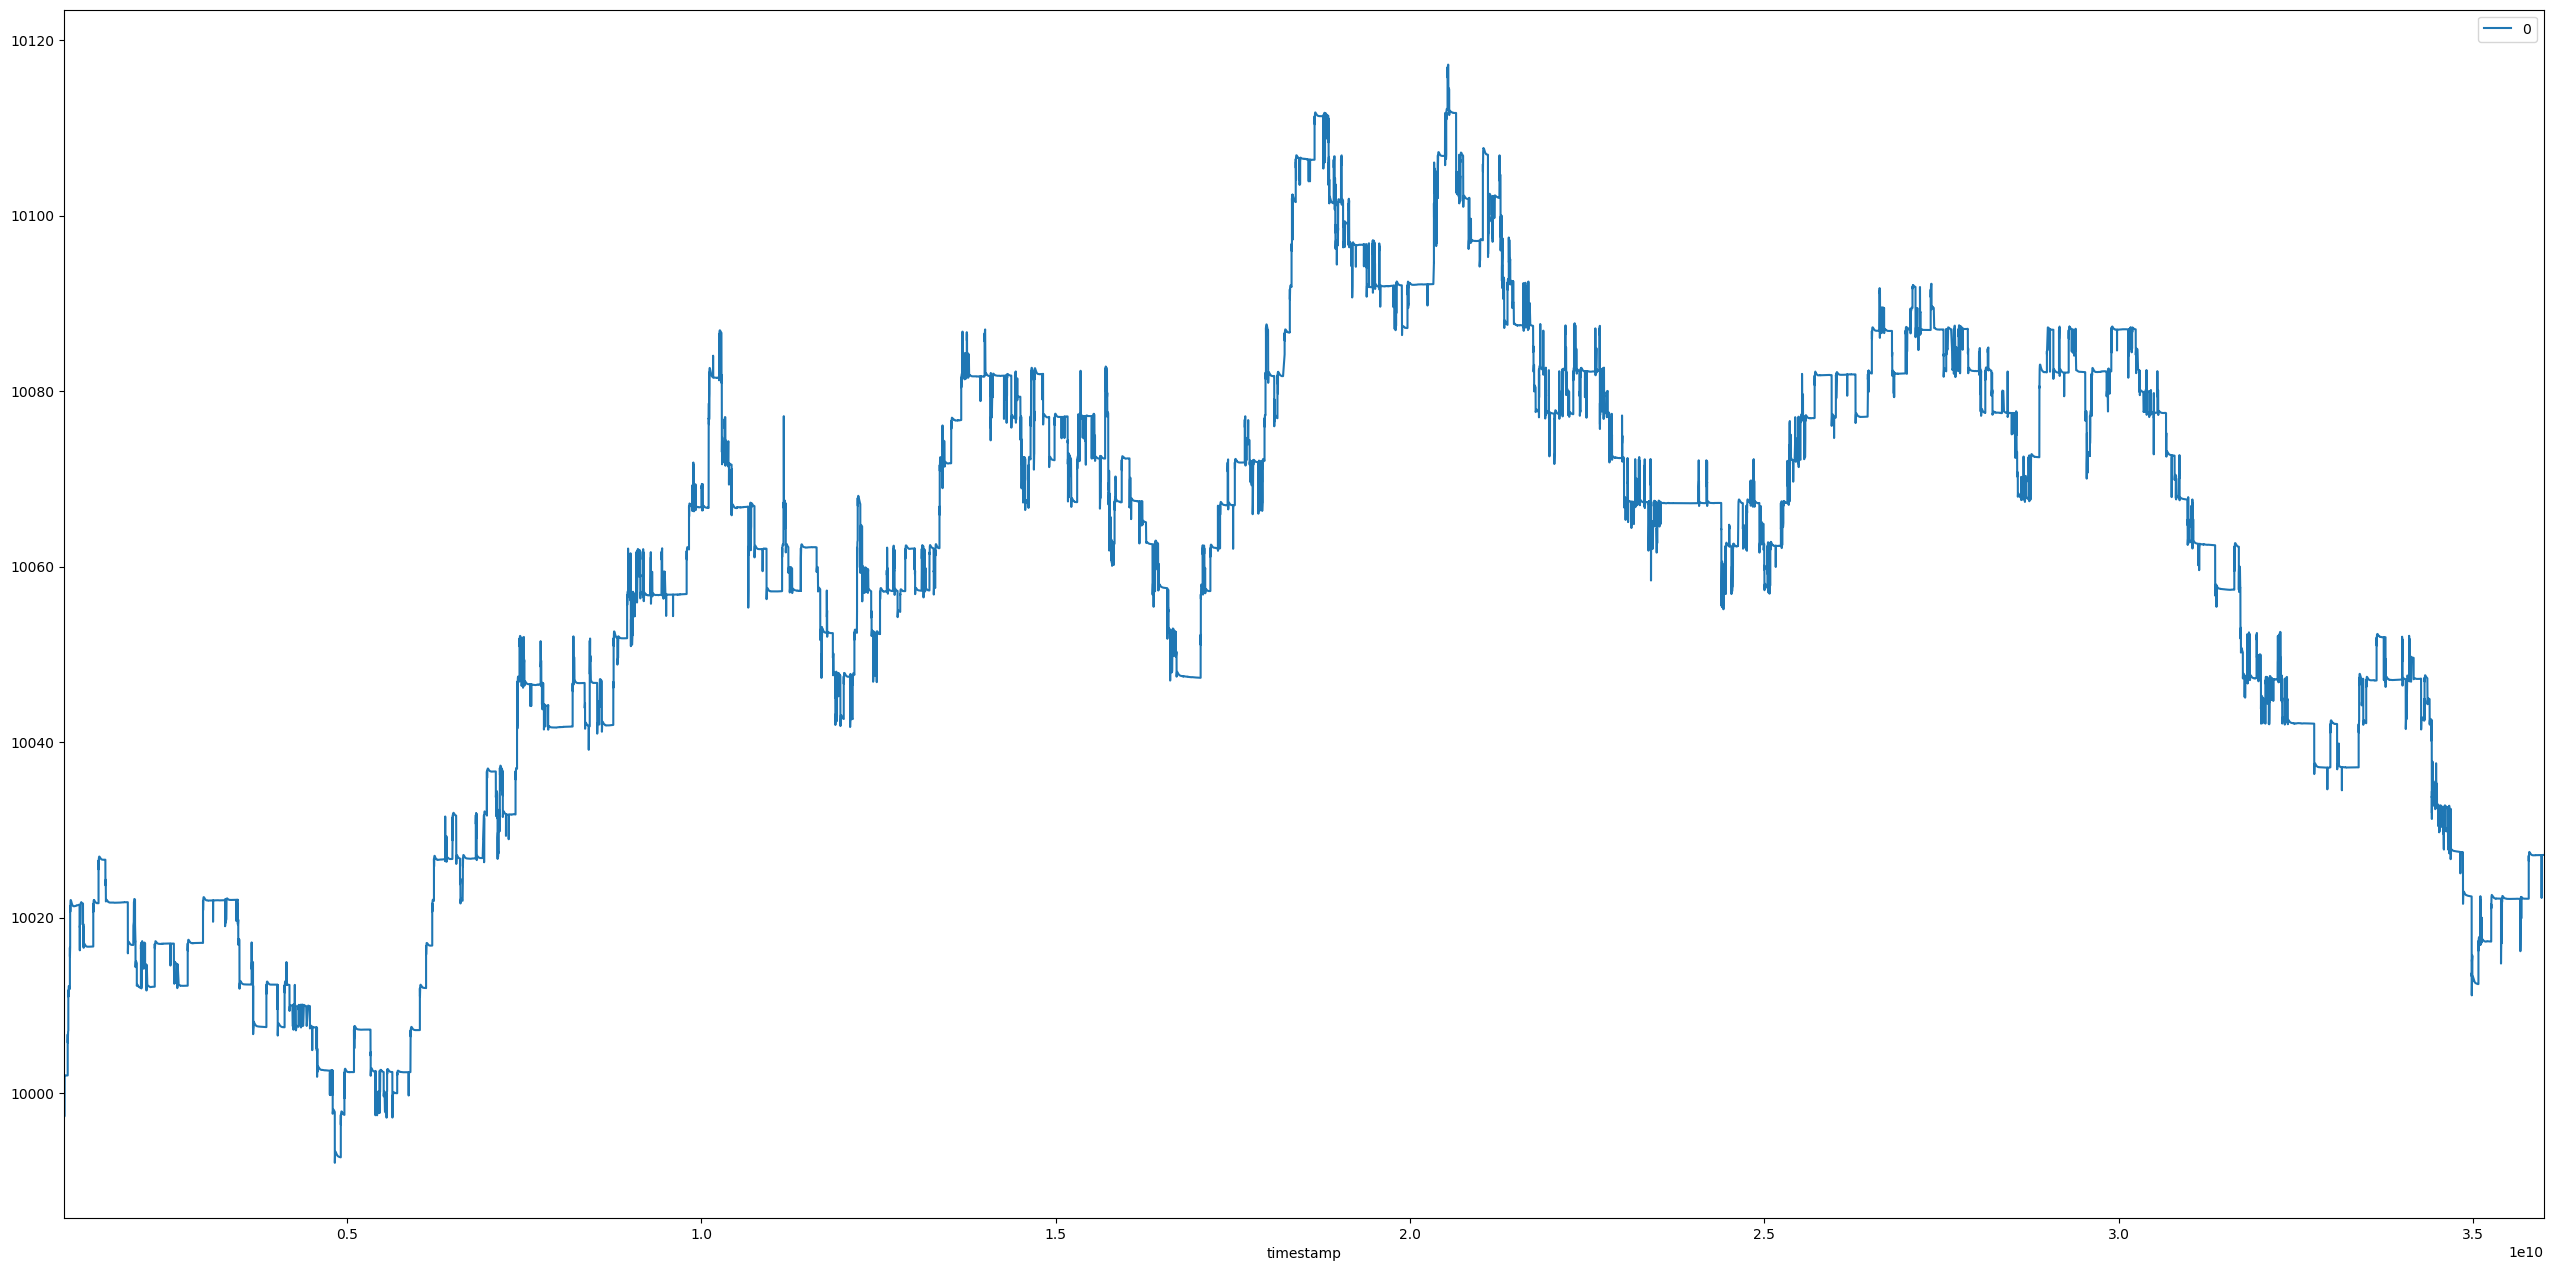

In [34]:
x.plot()

Okay! It is all set. I have also implemented the entire process to generate fair prices at `main.py`. Please take a look at it.